# Ex 2 - Transfer learning

Group: 12
###### Names: Luginbühl, Trottman, Shushack, Nann

In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds  # first: pip install tensorflow_datasets

from sklearn.metrics import accuracy_score

## Load the Dataset and visualize it

In [56]:
# Download and split the food101 dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    "food101",
    split=["train", "validation[:50%]", "validation[50%:]"],
    as_supervised=True,
    with_info=True
)

In [57]:
# Filter the dataset to keep the first 20 classes only.
N_CLASSES = 20
CLASS_NAMES = info.features['label'].names[:N_CLASSES]

train_ds = train_ds.filter(lambda img, label: label < N_CLASSES)
validation_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)
test_ds = test_ds.filter(lambda img, label: label < N_CLASSES)

In [58]:
# This step takes too much time. It is not madatory to execute it.
print("Training samples: %d" % train_ds.reduce(0, lambda x,_: x+1).numpy())
print("Validation samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())
print("Tests samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())

Training samples: 15000
Validation samples: 2514
Tests samples: 2514


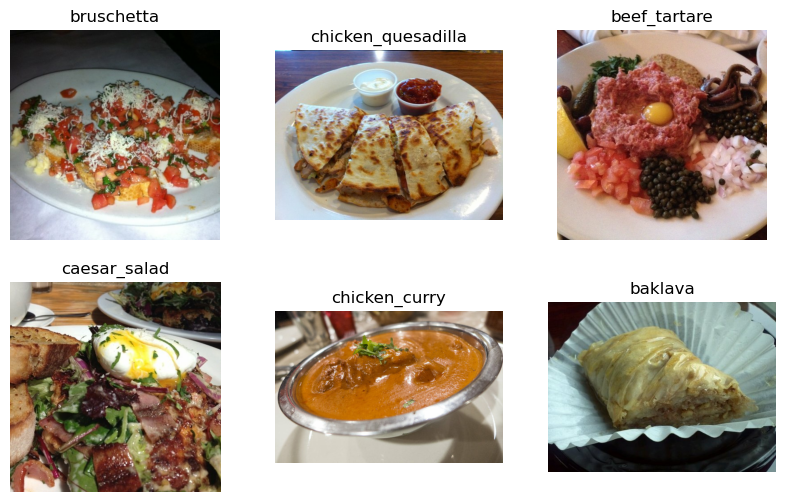

In [59]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

## Resize and normalize

In [60]:
# TODO Resize the images in the training, validation and test set

def resize_image(image, label):
    resized_image = tf.image.resize(image, (224, 224))  # habe irgendwo gelesen dass das noch ein gängiges format ist
    return resized_image, label

train_ds = train_ds.map(resize_image)
validation_ds = validation_ds.map(resize_image)
test_ds = test_ds.map(resize_image)

In [61]:
# Normalize the images

def normalize_image(image, label):
    normalized_image = tf.image.per_image_standardization(image)
    return normalized_image, label

train_ds = train_ds.map(normalize_image)
validation_ds = validation_ds.map(normalize_image)
test_ds = test_ds.map(normalize_image)

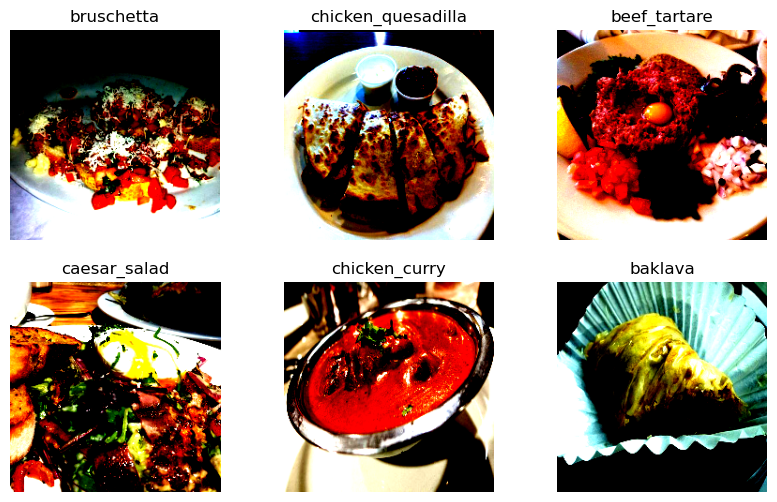

In [62]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

In [63]:
# One hot encode the labels

def encode_image(image, label):
    one_hot_label = tf.one_hot(label, N_CLASSES)
    return image, one_hot_label

train_ds = train_ds.map(encode_image)
validation_ds = validation_ds.map(encode_image)
test_ds = test_ds.map(encode_image)

## Data-Augmentation

In [64]:
# Optional define/implements data-augmentation

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image) 
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

train_ds = train_ds.map(augment_image)

## Training
### Step 1: Only train the head of the network

In [65]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models. 
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours. 
# A model like mobilenet is more than enough for the exercise.

from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.applications import EfficientNetB0

base_model = MobileNetV2(weights='imagenet', include_top=False)
# base_model = EfficientNetB0(weights='imagenet', include_top=False)

# Freeze the base_model
base_model.trainable = False

# Create the model structure
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 20)                25620     
                                                                 
Total params: 2,283,604
Trainable params: 25,620
Non-trainable params: 2,257,984
_________________________________________________________________
CPU times: user 791 ms, sys: 40.5 ms, total:

In [66]:
%%time

# does not work without specifying a batch size (shape does not match otherwise)
batch_size = 56
train_ds = train_ds.batch(batch_size)
validation_ds = validation_ds.batch(batch_size)


# Compile the model with your optimizer, your loss and your metrics
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Optional: Define and use callbacks
callbacks = []

step1_history = model.fit(train_ds, epochs=10, validation_data=validation_ds,
                          callbacks=callbacks) # You should us a relatively big learning rate: 1e-3

Epoch 1/10


In [ ]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(step1_history, 'loss')

NameError: name 'step1_history' is not defined

### Step 2: Fine-Tune the whole model

In [ ]:
%%time


# Unfreeze the pretrained base. 
base_model.trainable = True

# Compile the model again
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Retrain the model
step2_history = model.fit(train_ds, epochs=10, validation_data=validation_ds) # You should us a small learning rate: for example 1e-5 or 1e-6

In [ ]:
plot_history(step2_history, 'loss')

## Test the fine-tuned model

In [ ]:
%%time
# Predict the test set
y_pred = model.predict(test_ds, verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

In [ ]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

In [ ]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds])+1)/2*255
    test_examples = test_examples.astype("uint32")
    
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)